# Zip Code Predictions 
### Ronen Reouveni 
### IST 718 
### Lab 6

Land development is one of the biggest investment fields in the US and the world. Like all other investment vehicles, it has been revolutionized by Data Science and analytics. In this report, I will calculate historical returns and then predict future returns on single family real estate broken down by zip code. This analysis will be used to recommend which zip codes are the best investment. Investor sentiment is that both confidence and predicted return are most important. No money should be left on the table, but reccomended investments should be based on confident predictions.

In [ ]:
#import packages
import pandas as pd
from matplotlib import pyplot as plt
from pandas import to_datetime
from pandas import DataFrame 
from fbprophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.metrics import mean_absolute_error

import numpy as np
from numpy import array
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional

from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D




In [ ]:
#read data
timeData = pd.read_csv('/content/Zip_Zhvi_SingleFamilyResidence.csv')

In [ ]:
#transpose dataset
timeData_trans = timeData.T

In [ ]:
#extract info and drop unused cols
zipCodes = timeData_trans.loc['RegionName',:]
timeData_trans.columns = zipCodes
timeData_trans = timeData_trans.drop(['RegionID','RegionName',
                                      'RegionType','StateName'])
timeData_transGraph = timeData_trans

In [ ]:
#split metadata from zip codes
metaData = timeData_trans.iloc[:5,]
timeData_trans = timeData_trans.iloc[5:,]

In [ ]:
#drop all columns with NA's
#I am only interested in zips with complete data
timeData_trans = timeData_trans.dropna(axis='columns')
timeData_transGraph = timeData_transGraph.dropna(axis='columns')

timeData_trans.isna().sum().sum()

0

In this above code block I remove all columns with a missing zip code. This leaves us with around 14,000 zip codes. A missing data point for a zip code implies that the zip code did not exist at that time. Therefore I will focus on zip codes that have all of their data points and feed data all the way back to 1996 into the predictions for 2020/2021. 

In [ ]:
#create 3 custom functions for querying data, aggregating, and graphing
#this allows me to then easily graph any state, zip, county, all on the same graph easily
def getData(geo,rawSet):
  #check which type the geo is, state, city, metro, or zip
  #extract needed data and drop the rest
  if geo in list(set(rawSet.loc['State',:])):
      myData = rawSet.loc[:,rawSet.loc['State']==geo]
      myData = myData.drop(['State','City','CountyName','Metro','SizeRank'])
      return(myData,geo)
  if geo in set(rawSet.loc['City',:]):
      myData = rawSet.loc[:,rawSet.loc['City']==geo]
      myData = myData.drop(['State','City','CountyName','Metro','SizeRank'])
      return(myData,geo)
  if geo in set(rawSet.loc['CountyName',:]):
      myData = rawSet.loc[:,rawSet.loc['CountyName']==geo]
      myData = myData.drop(['State','City','CountyName','Metro','SizeRank'])
      return(myData,geo)
  if geo in set(rawSet.loc['Metro',:]):
      myData = rawSet.loc[:,rawSet.loc['Metro']==geo]
      myData = myData.drop(['State','City','CountyName','Metro','SizeRank'])
      return(myData,geo)
  if geo in rawSet.columns:
      myData = rawSet.loc[:,geo]
      myData = myData.drop(['State','City','CountyName','Metro','SizeRank'])
      return(myData,geo)
  else:
    print('location not found')

def graphAverage(pandas_obj):
  #loop over inputs and graph it all together 
  tempDF = pd.DataFrame()
  tempIndex = pandas_obj[0][0].index
  for tup in pandas_obj:
      pandas_frame = tup[0]
      avg = list(pandas_frame.sum(1)/len(pandas_frame.columns))
      tempDF[tup[1]] = avg
  tempDF.index = tempIndex
  tempDF.index = pd.to_datetime(tempDF.index)
  tempDF.plot(y=list(tempDF.columns.values), figsize = (15,15))

#graph an individual zip
def graphZip(zipcode): 
  getData(zipcode,timeData_transGraph)[0].plot(y=[zipcode], figsize=(15,15), rot = 90)


The functions above make working with the data very easy. Using them, I am able to query the data and graph any geographic location all on the same graph. This allows me to stack areas and visualize zip codes, cities, counties, or states all together or individually. It is essential to remember that these visualizations will differ based on how missing values are dealt with. In this analysis, all zip codes with missing data are simply removed. 

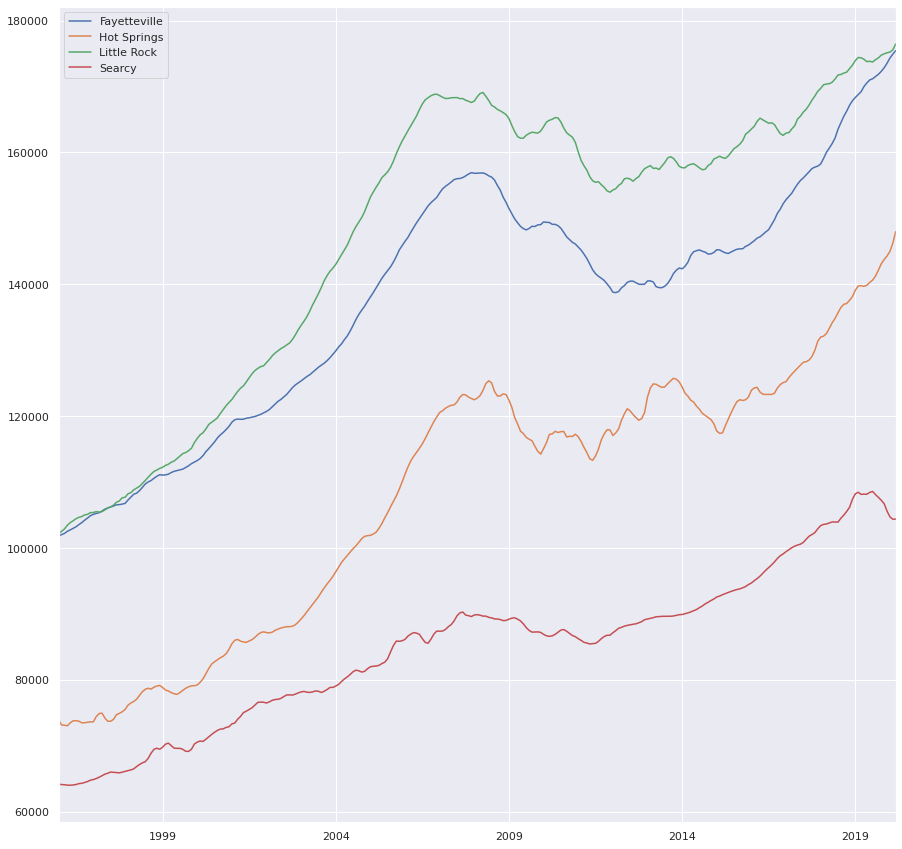

In [ ]:
#Hot Springs, Little Rock, Fayetteville, Searcy
graphAverage([getData('Fayetteville',timeData_transGraph)
             ,getData('Hot Springs',timeData_transGraph)
             ,getData('Little Rock',timeData_transGraph)
             ,getData('Searcy',timeData_transGraph)])

In this next vizualization I show how my custom function is able to graph states all together. Notice the high growth of California as opposed to the other 3 states. 

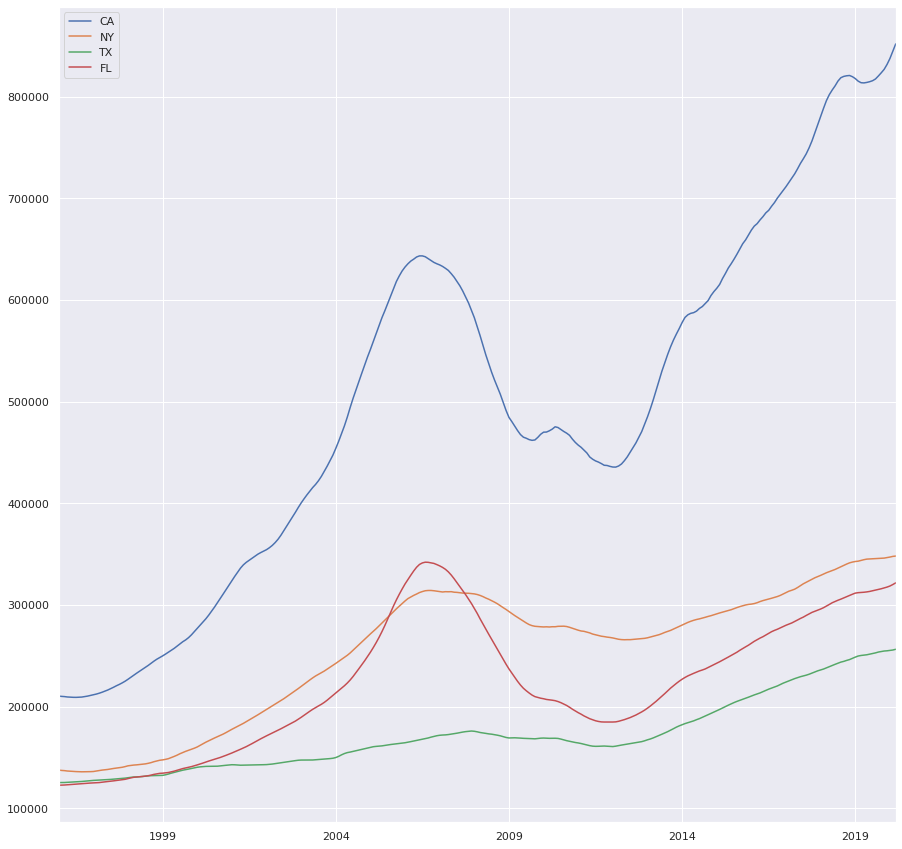

In [ ]:
graphAverage([getData('CA',timeData_transGraph)
             ,getData('NY',timeData_transGraph)
             ,getData('TX',timeData_transGraph)
             ,getData('FL',timeData_transGraph)])

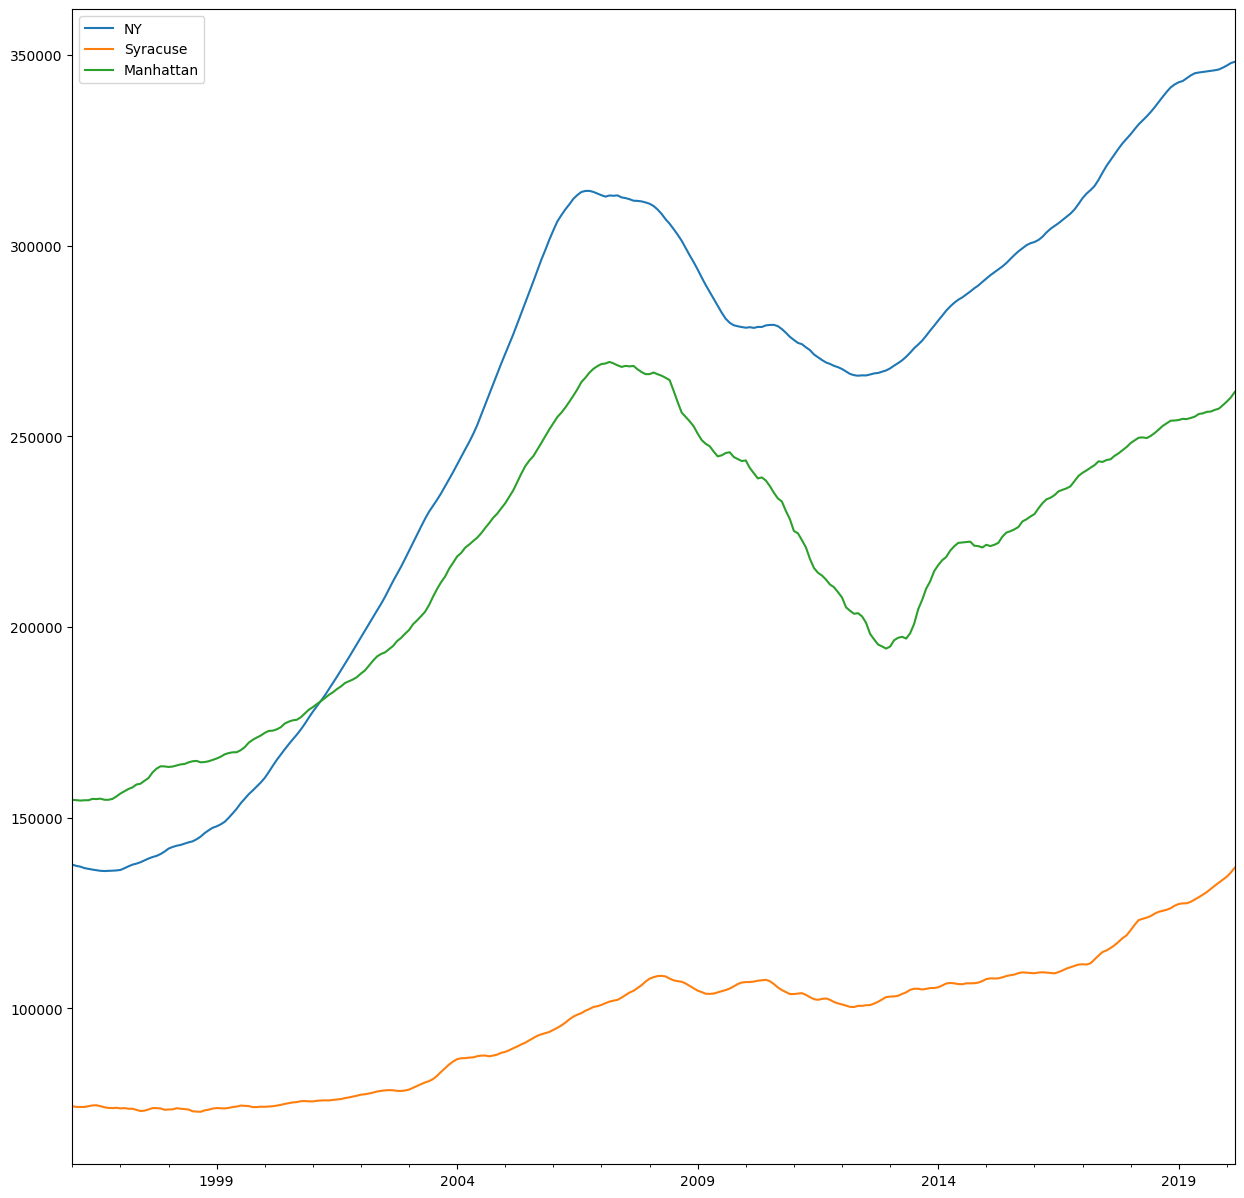

In [ ]:
graphAverage([getData('NY',timeData_transGraph)
             ,getData('Syracuse',timeData_transGraph)
             ,getData('Manhattan',timeData_transGraph)])

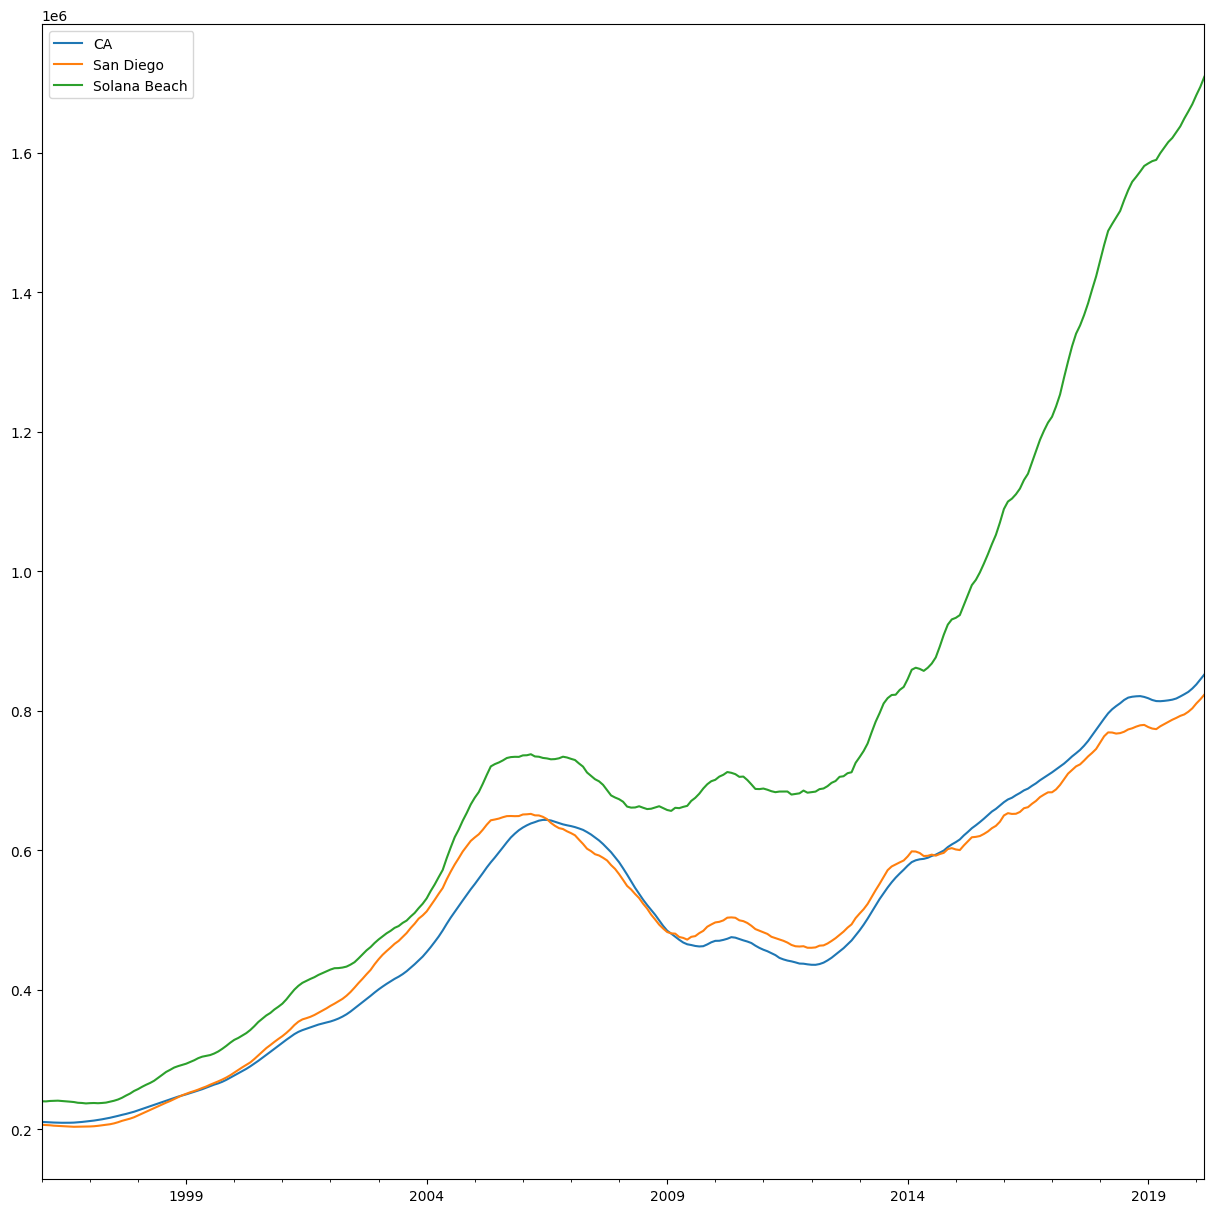

In [ ]:
graphAverage([getData('CA',timeData_transGraph)
             ,getData('San Diego',timeData_transGraph)
             ,getData('Solana Beach',timeData_transGraph)])

This above vizualization shows the best thing about this function. I am able to show a 'stack' of related locations. Starting with California, then San Diego, and then a wealthy city within San Diego. This gives a sort of hierarchy of growth over time.  

In [ ]:
#this function is unused but i left it in for future analysis 
#it takes a list of locations and creates a new frame
#aggregation 
def reduceDown(listOflocations, timeseries):
  newFrame = pd.DataFrame(timeseries.index)
  newFrame = newFrame.iloc[4:,:]
  for place in listOflocations:
    currentFrame = getData(place, timeseries)

    avg = list(currentFrame[0].sum(1)/len(currentFrame[0].columns))
    newFrame[currentFrame[1]] = avg
  newFrame.index = newFrame.iloc[:,0]
  newFrame = newFrame.iloc[: , 1:]

  return(newFrame)

In [ ]:
#create list of dates one year past the final year in the data 
future = list()
for i in range(4, 13):
	date = '2020-%02d-29' % i
	future.append([date])
for i in range(1, 4):
	date = '2021-%02d-28' % i
	future.append([date])

future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])


In [ ]:
#custom function takes a timeseries and predicts using prophet
#calculates percent return 
#calculates worst case return 
#calculates best case return 
def predictAll(timeSeries):

  #create empty data
  zipReturns = []
  zipReturnsBestCase = []
  zipReturnsWorstCase = []
  newRows = timeSeries.columns
  finalFrame = pd.DataFrame(newRows)

  #loop through inputs 
  for (columnName, columnData) in timeSeries.iteritems():
    #establish model make predictions

    model = Prophet(weekly_seasonality=False, daily_seasonality=False)
    currentZip = timeSeries[columnName]

    df = pd.DataFrame(currentZip)
 
    df['ds'] = df.index
    df['y'] = df[columnName] 
    model.fit(df)
    forecast = model.predict(future)

    #calculate needed metrics
    zipReturns.append((forecast.loc[11,'yhat']-forecast.loc[0,'yhat'])/forecast.loc[0,'yhat'])
    zipReturnsBestCase.append((forecast.loc[11,'yhat_upper']-forecast.loc[0,'yhat'])/forecast.loc[0,'yhat'])
    zipReturnsWorstCase.append((forecast.loc[11,'yhat_lower']-forecast.loc[0,'yhat'])/forecast.loc[0,'yhat'])

  #put all data into final frame to return 
  finalFrame['predicted'] = zipReturns
  finalFrame['bestCase'] = zipReturnsBestCase
  finalFrame['worstCase'] = zipReturnsWorstCase
  return(finalFrame)

The function I created above is one of the foundational pieces of the anlysis. It is able to build a series of models using facebook's prophet. This means it can be passed an entire dataframe of zip codes and create an individual prophet model for each zip code. Most importantly, it also calculates the percent return for predictions 1 year into the future. Furthermore, it calculates the return on the lower bound and upper bound. This gives the potential return under the worst case scenerio and best case scenerio. 

A problem with dealing with so many zip codes is that many are useless and computationally expensive to build models on. Furthermore, because the data is based on only past home values, zip codes with recently low returns will not be predicted to have high returns. Therefore, I calculate historic property returns going back 5 years. This can then be ordered and used to reduce computational expense. 

In [ ]:
#establish a huerstic to lower computational expense
dataHueristic = timeData_trans.iloc[228:,:] # go back 5 years exactly

#calculate percent change over 5 years
vector = dataHueristic.pct_change(periods=dataHueristic.shape[0]-1).iloc[-1,:]
#sort
historicReturns = vector.sort_values(ascending=False)

In [ ]:
historicFrame = pd.DataFrame()
historicFrame['zip'] = historicReturns.index
historicFrame['returns'] = historicReturns.values
historicFrame = historicFrame.iloc[:-1,]
historicFrame #show historic returns of each zip 

,zip,returns
0,43205,2.60025
1,30310,2.10543
2,32208,1.69979
3,75224,1.68786
4,90211,1.67312
...,...,...
13219,6840,-0.169024
13220,15434,-0.197439
13221,71752,-0.199227
13222,79901,-0.224915


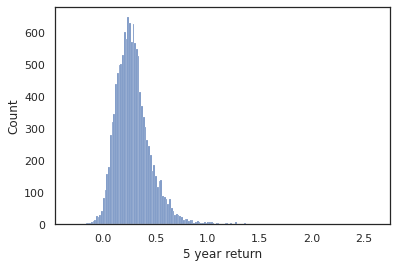

In [ ]:
#show distribution of returns 
sns.histplot(data=historicReturns)
plt.xlabel('5 year return')
plt.show()

Historic returns are usually normally distributed, apart from some extreme outliers, the distribution of historic returns on all 13,224 zip codes is close to normal. 

In [ ]:
#extract more data to vizualize
metaDataTrans = metaData.T
metaDataTrans['zip'] = metaDataTrans.index
historicReturnsMERGE = pd.DataFrame(historicReturns)
historicReturnsMERGE['zip'] = historicReturnsMERGE.index
stateReturns = historicReturnsMERGE.merge(metaDataTrans, how='left', left_on='zip', right_on='zip')
stateReturns = stateReturns.iloc[:-1,[0,3]]
stateReturns.columns = ['returns','State']
stateReturns.returns = stateReturns.returns.astype('float')
stateMeanReturn = stateReturns.groupby('State')['returns'].mean()
stateVarReturn = stateReturns.groupby('State')['returns'].std()

In [ ]:
#put extracted data into correct format
df = pd.DataFrame()
df['mean'] = stateMeanReturn
df['var'] = stateVarReturn
df['group'] = stateVarReturn.index

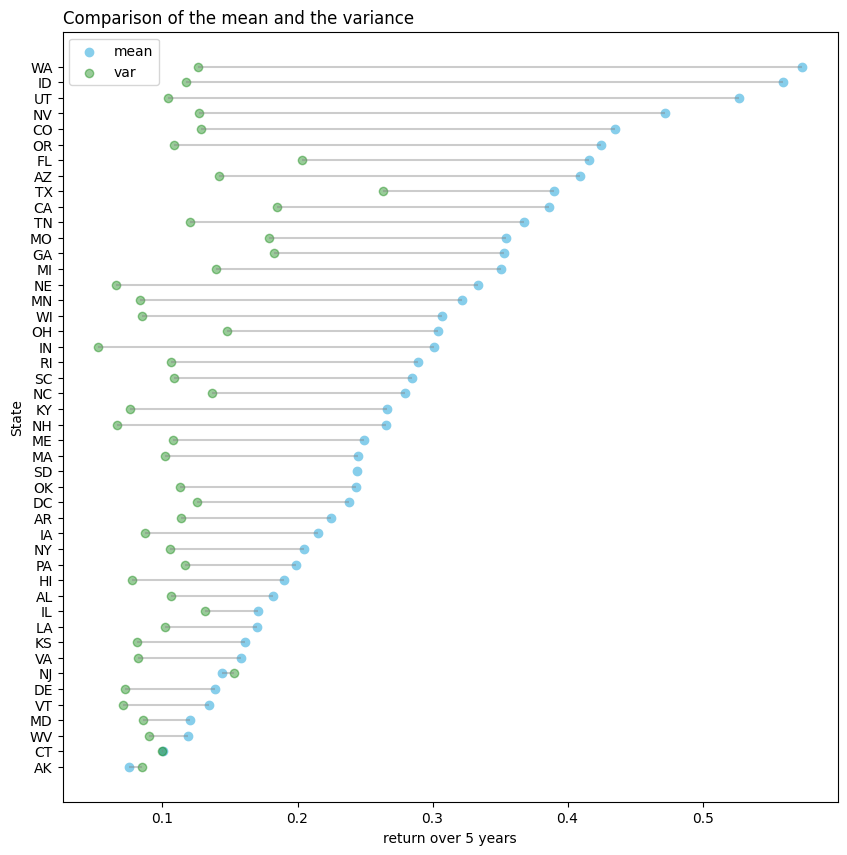

In [ ]:
#https://www.python-graph-gallery.com/184-lollipop-plot-with-2-groups

#this code graphs state mean returns and standard deviation 
ordered_df = df.sort_values(by='mean')
my_range=range(1,len(df.index)+1)
plt.figure(figsize=(10, 10))

plt.hlines(y=my_range, xmin=ordered_df['mean'], xmax=ordered_df['var'], color='grey', alpha=0.4)
plt.scatter(ordered_df['mean'], my_range, color='skyblue', alpha=1, label='mean')
plt.scatter(ordered_df['var'], my_range, color='green', alpha=0.4 , label='var')
plt.legend()
 
plt.yticks(my_range, ordered_df['group'])
plt.title("Comparison of the mean and the variance", loc='left')
plt.xlabel('return over 5 years')
plt.ylabel('State')

plt.show()

This visualization shows the mean historic return over the past 5 years by state and the variance. The blue dot is the return and the green dot is the variance. A blue dot far to the right implies higher returns, while a green dot far to the left implies low variance of returns within the state. This is very beneficial becuase it shows if a state had high growth but the growth itself was asymetric accross the components of the state. Washington for example has high returns and low variance, meaning the growth was more or less evenly distributed across the state. Texas for example, had a high growth but high variance. This means that the growth was only specific areas of the state. 

In [ ]:
historicReturns.quantile([0.25,0.5,0.75,.90,.95,.99])

0.25    0.172755
0.50    0.266589
0.75    0.370147
0.90    0.502349
0.95    0.596421
0.99    0.851710
Name: 2020-03-31, dtype: float64

In [ ]:
#only use high performing zip codes over the past 5 years 
zipIndex = historicReturns[historicReturns > .85].index
bestZipCodes = timeData_trans.loc[:,zipIndex]

In [ ]:
#call the function created above to predict using prophet
#the custom function created above makes this very easy
predictionFrame = predictAll(bestZipCodes)
predictionFrame.to_csv('predict_135.csv') #save to CSV 
predictionFrame

,RegionName,predicted,bestCase,worstCase
0,43205,0.131856,0.174495,0.092897
1,30310,0.142112,0.172980,0.108660
2,32208,0.139217,0.169471,0.109760
3,75224,0.120318,0.132113,0.108308
4,90211,0.102710,0.115964,0.089550
...,...,...,...,...
130,33607,0.089983,0.115563,0.065532
131,98408,0.080498,0.094251,0.063506
132,7106,0.054909,0.087000,0.016531
133,33168,0.098951,0.129711,0.070120


At this point the function that builds the prophet model is used and the results are stored into a dataframe shown above. These are the top performing zip codes forecasted into the future. It is important to remember, the function I created that does this does not split into train and test. It simply uses all the data and forecasts 12 months into the future. 

In [ ]:
#create another custom function 
#this makes the predictions with prophet
#it now uses train and test data
#it checks if the true value at the end of the test time is within the confidence interval of the prediction 
predError = []
containsPred = []

def makeEval(currentZip):
  df = pd.DataFrame(bestZipCodes.loc[:,currentZip])
  df['ds'] = df.index
  df['y'] = df[currentZip]

  train = df.drop(df.index[-12:])


  model = Prophet(changepoint_prior_scale = .25, seasonality_mode = 'multiplicative', changepoint_range = .70, interval_width = .95)

  model.fit(train)
  future = list()

  for i in range(1, 13):
	  date = '2020-%02d' % i
	  future.append([date])
  future = DataFrame(future)
  future.columns = ['ds']
  future['ds'] = df.index[-12:]


  forecast = model.predict(future)
  y_true = df['y'][-12:].values
  y_pred = forecast['yhat'].values
  error = mean_absolute_error(y_true, y_pred)
  predError.append(error)



  if y_true[-1] > forecast['yhat_lower'].values[-1] and y_true[-1] < forecast['yhat_upper'].values[-1]:   
    containsPred.append(1)
  else:
    containsPred.append(0)

This function takes care of calculating the evaluations of the prophet modeling. With the above function, I split the data into train and test, where the test set is 12 months. This allows me to look at each prediction's lower and upper bound, and then evaluate if the true value falls into the confidance interval. Between this and mean absolute error I have confidence I can truly evaluate the validity of the model. 

In [ ]:
#call the above function 
for val in predictionFrame['RegionName']:
  makeEval(val)

In [ ]:
#append data to frame
predictionFrame['error'] = predError
predictionFrame['contains'] = containsPred

In [ ]:
#now this frame also shows the error for each zip
#it also shows if the true value is in the confidence interval 
predictionFrame

,RegionName,predicted,bestCase,worstCase,error,contains
0,43205,0.131856,0.174495,0.092897,60469.352720,0
1,30310,0.142112,0.172980,0.108660,45717.150298,0
2,32208,0.139217,0.169471,0.109760,18418.348204,0
3,75224,0.120318,0.132113,0.108308,21425.482526,0
4,90211,0.102710,0.115964,0.089550,236544.185133,0
...,...,...,...,...,...,...
130,33607,0.089983,0.115563,0.065532,1427.409622,1
131,98408,0.080498,0.094251,0.063506,15870.144240,0
132,7106,0.054909,0.087000,0.016531,57243.658397,0
133,33168,0.098951,0.129711,0.070120,7326.858003,1


In [ ]:
predictionFrame['contains'].sum() #only 42 of the predictions are actually within the conf interval

42

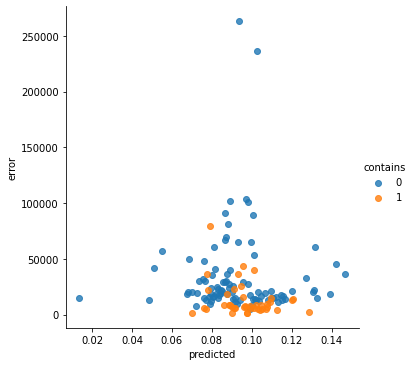

In [ ]:
#show predicted against error 
#show if the predictions were within confidence interval
sns.lmplot( x="predicted", y="error", hue="contains", data=predictionFrame, fit_reg=False) 

This visualization along with the results above show that only 42/135 true values were within the confidence interval. This is not very acceptable. It implies that a more advanced model may be needed to better fit the data. Next I train and test a Bidirectional LSTM with 100 nodes and 1,000 epochs. This will hopefully do a better job at predicting returns. 

In [ ]:
#extract the 20 best zips according to prophet 
predictionFrame = predictionFrame.sort_values(by='predicted', ascending=False)
predictionFrame_LSTM = predictionFrame.iloc[:20,:]

In [ ]:
#small code snippets taken from here
#https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

#majority of this is custom by me 
#these functions turn the data into sequences
#they model a bidirectional LSTM
#it makes predictions
#it calculates MAE 

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 

def makeData_andTrain(zipCode):
  series = np.array(bestZipCodes[zipCode].astype('int'))
  seriesTrain = series[:-12]
  seriesTest = series[-15:]


  n_steps = 3

  X, y = split_sequence(seriesTrain, n_steps)
  X_test, y_test = split_sequence(seriesTest, n_steps)



  n_features = 1
  model = Sequential()
  model.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(n_steps, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')

  X = X.reshape((X.shape[0], X.shape[1], n_features))
  model.fit(X, y, epochs=1000, verbose=0)


  start = X_test[0]
  x_input = array(start)
  predictions = []

  for i in range(len(y_test)):
    x_input_pass = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input_pass, verbose=0)
    x_input = np.delete(x_input, 0)
    x_input = np.append(x_input, yhat)
    predictions.append(yhat)

  y_test_change = list(y_test.flatten())

  actualPredictions = []
  for val in predictions:
    actualPredictions.append(predictions[0][0][0])
  return(mean_absolute_error(actualPredictions, y_test_change))



def futurePrediction(zipCode):
  series = np.array(bestZipCodes[zipCode].astype('int'))

  # choose a number of time steps
  n_steps = 3
  # split into samples
  X, y = split_sequence(series, n_steps)
 # X_test, y_test = split_sequence(seriesTest, n_steps)

  n_features = 1
  model = Sequential()
  model.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(n_steps, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  X = X.reshape((X.shape[0], X.shape[1], n_features))
  model.fit(X, y, epochs=1000, verbose=0)

  start = X[-1]

  x_input = array(start)
  predictions = []

  for i in range(12):
    x_input_pass = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input_pass, verbose=0)
    predictions.append(yhat)
    x_input = np.delete(x_input, 0)
    x_input = np.append(x_input, yhat)
    predictions.append(yhat)
  return(predictions, (yhat[-1]-y[-1])/y[-1])

def runFullLSTMsuite(zips):
  return(makeData_andTrain(zips),  futurePrediction(zips))

The above code block trains and tests a LSTM. Getting the data in the correct format is very involved for this process. That is because when a prediction is made, it needs to be added to the window which is fed into the LSTM for the next sequence. Finally, the code also calculates the returns and combines all functions that can be called easily with a loop. 

In [ ]:
#call the functions above with runFullLSTMsuite
zipsToCheck = predictionFrame_LSTM['RegionName']

LSTM_MAE = []
LSTM_prediction = []
for zip in zipsToCheck:
  currentZip = runFullLSTMsuite(zip)
  LSTM_MAE.append(currentZip[0])
  LSTM_prediction.append(currentZip[1][1])

In [ ]:
#add LSTM predictions to the prophets
predictionFrame_LSTM['LSTM_MAE'] = LSTM_MAE
predictionFrame_LSTM['LSTM_prediction'] = LSTM_prediction

In [ ]:
predictionFrame_LSTM.to_csv('fullpredict_.csv') #send to csv

In [ ]:
predictionFrame_LSTM

,RegionName,predicted,bestCase,worstCase,error,contains,LSTM_MAE,LSTM_prediction
6,30032,0.146844,0.183390,0.109156,36067.034048,0,3456.726562,[0.2160514606483998]
1,30310,0.142112,0.172980,0.108660,45717.150298,0,10670.385417,[0.04205906188708028]
2,32208,0.139217,0.169471,0.109760,18418.348204,0,3300.658854,[0.06249496626669157]
85,76104,0.132753,0.156189,0.107037,14477.275651,0,2350.028646,[-0.16079419097038872]
0,43205,0.131856,0.174495,0.092897,60469.352720,0,11618.406250,[0.0823983764281419]
70,92285,0.131428,0.164870,0.096869,22277.037737,0,1604.968750,[-0.022740400979211393]
7,75141,0.130465,0.146908,0.113376,20082.958972,0,4420.968750,[0.12609103081550596]
11,75223,0.128585,0.152899,0.102876,2270.575041,1,7975.062500,[0.16432808831631665]
5,30311,0.126963,0.155459,0.098627,32395.372868,0,7039.406250,[0.15775976348161957]
30,75233,0.120766,0.135942,0.106166,13613.931187,1,1510.239583,[0.03755854199938296]


Text(0, 0.5, 'Predicted return')

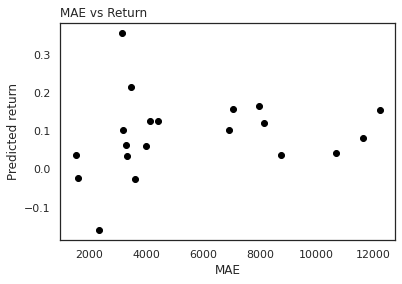

In [ ]:
#plot highest returns predicted by LSTM against the error 
plt.plot(predictionFrame_LSTM['LSTM_MAE'], predictionFrame_LSTM['LSTM_prediction'], 'o', color='black');
plt.title("MAE vs Return", loc='left')
plt.xlabel('MAE')
plt.ylabel('Predicted return')

For almost every observation the LSTM outperforms the prophet substantially. Three zip codes stand out as having the highest predicted performance. These are; 33711 with a predicted 36% return in 1 year, 30032 with a predicted 22% return in 1 year, and finally 75223 with a predicted 1 year return of 16%. We can vizualize these zip codes as shown below. 

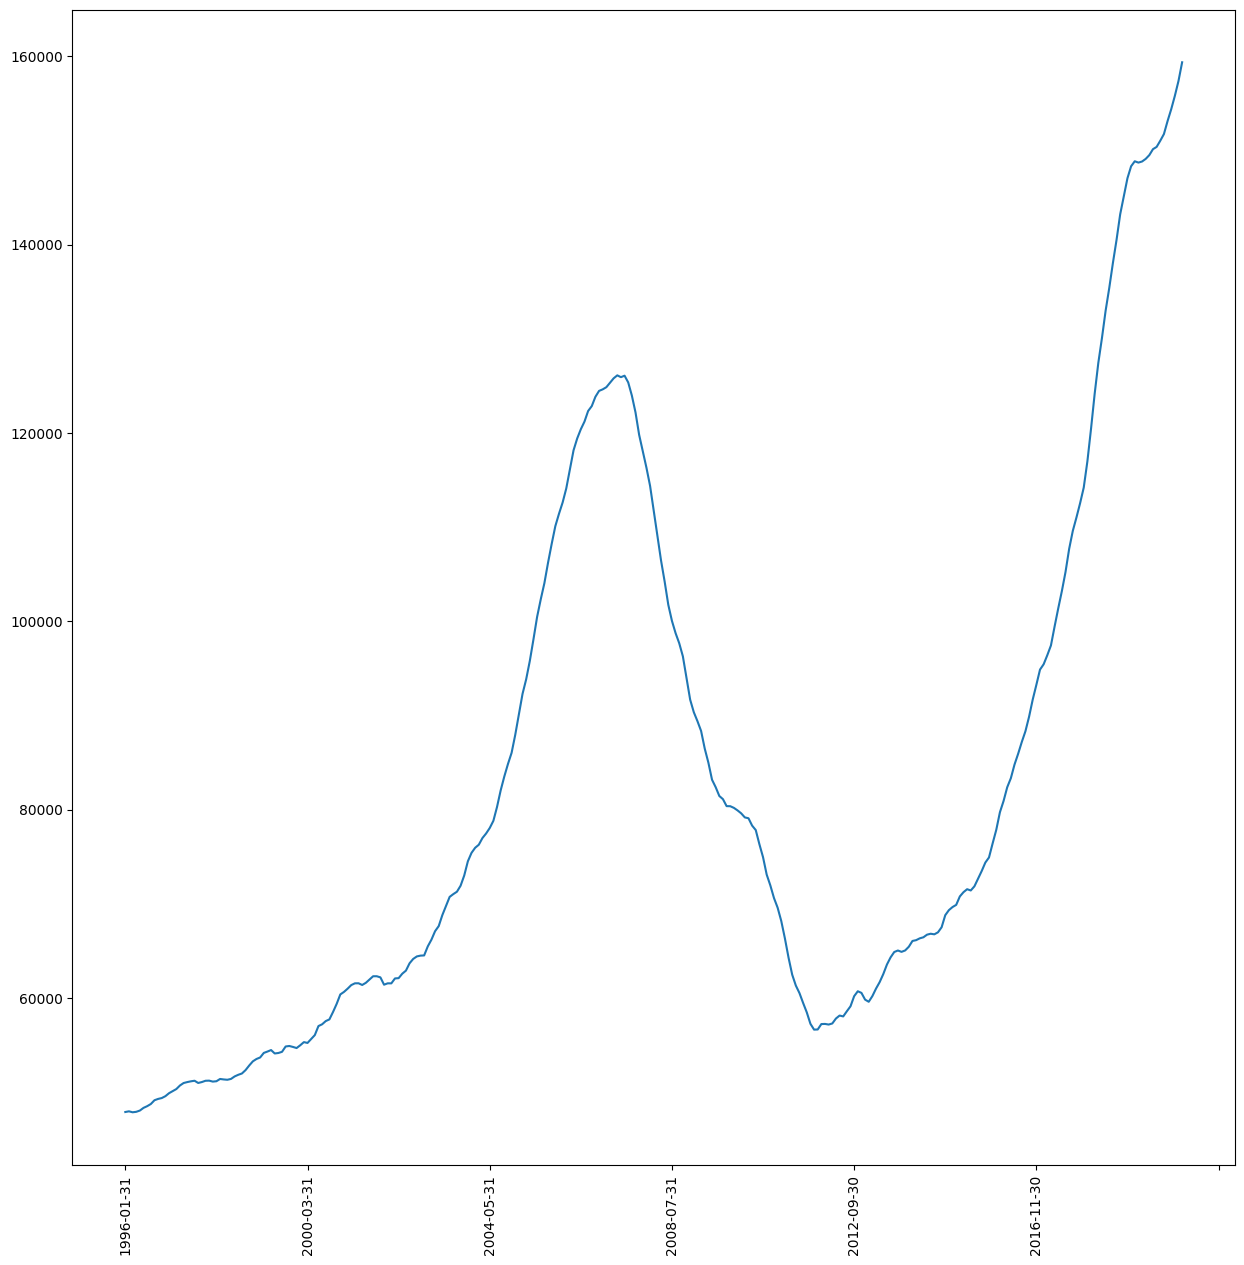

In [ ]:
graphZip(33711)

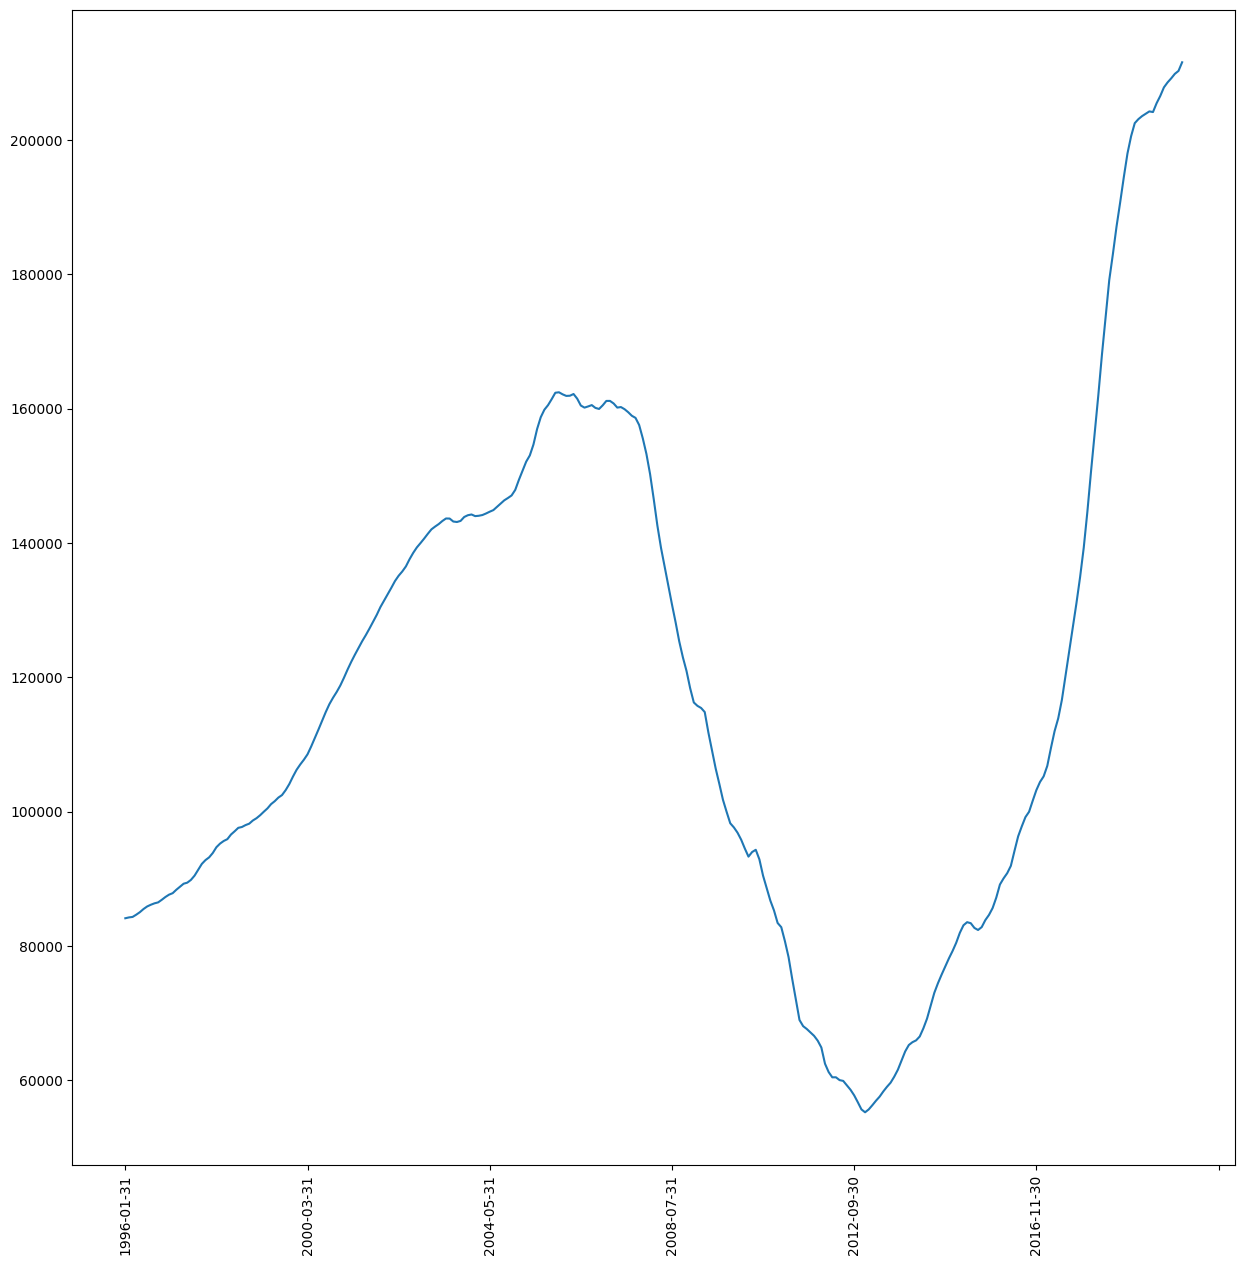

In [ ]:
graphZip(30032)

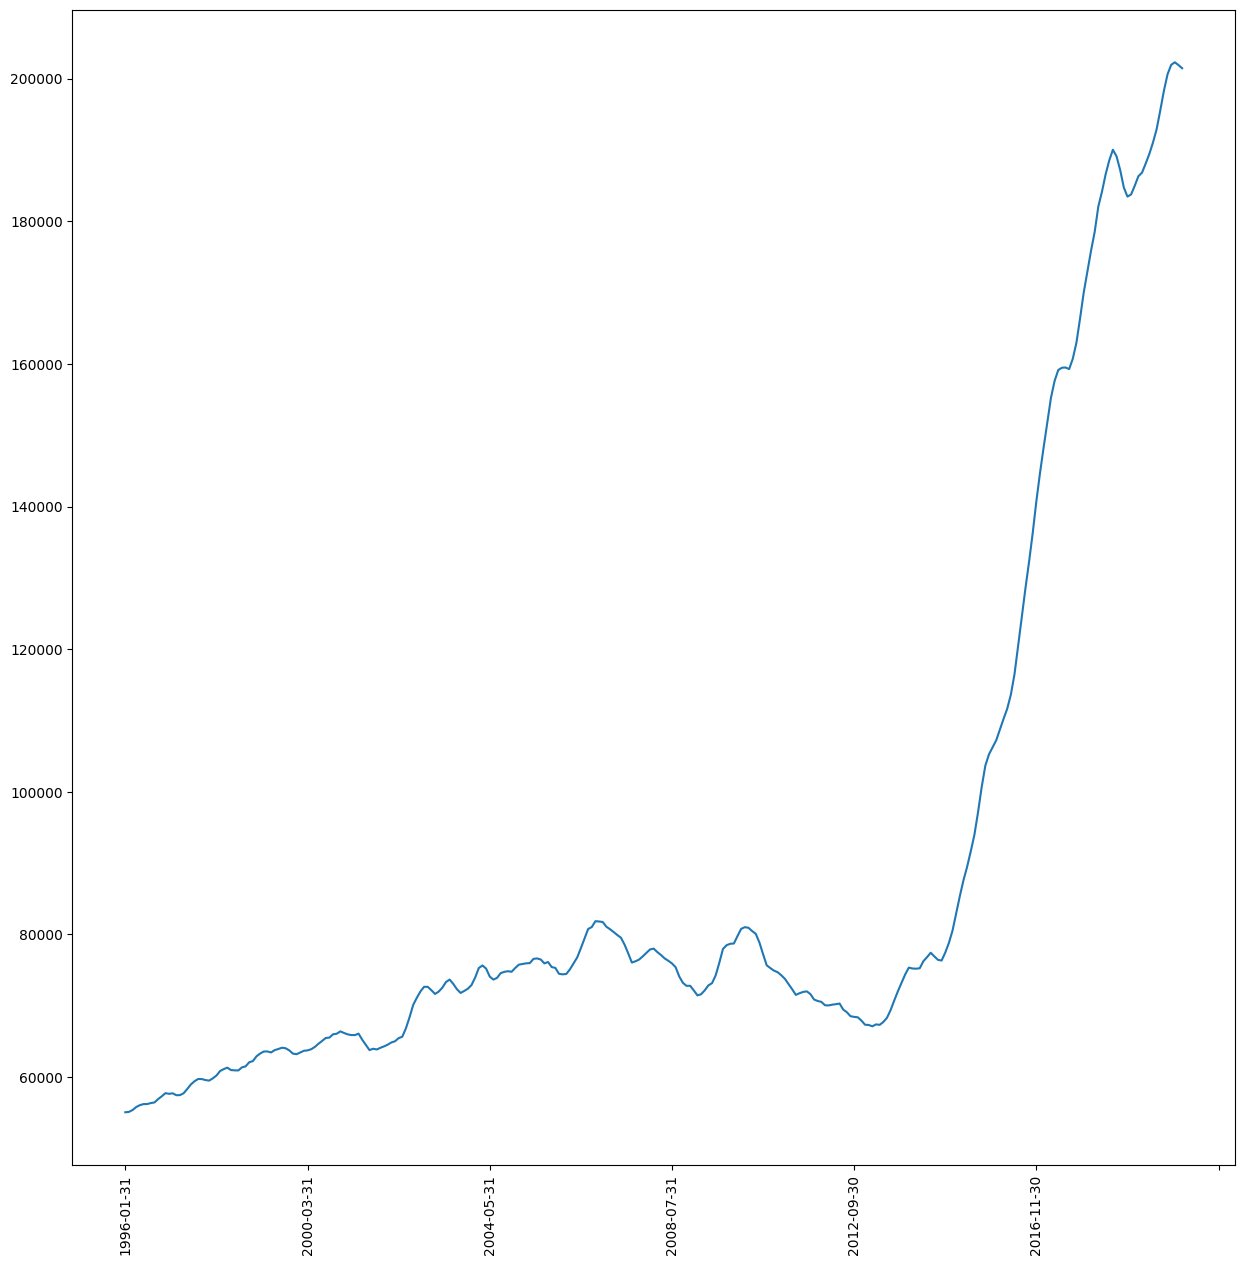

In [ ]:
graphZip(75223)

In [ ]:
returns = [.36,.22,.16]
mae = [3127.859375, 3456.726562,  7975.062500]
investmentFrame = metaData.loc[:,[33711, 30032, 75223]]
rowNames = list(investmentFrame.index)
rowNames.append('returns')
rowNames.append('mae')
investmentFrame.loc[len(investmentFrame.index)] = returns
investmentFrame.loc[len(investmentFrame.index)] = mae
investmentFrame.index= rowNames
investmentFrame

RegionName,33711,30032,75223
SizeRank,6181,1030,9113
State,FL,GA,TX
City,Saint Petersburg,Candler-Mcafee,Dallas
Metro,Tampa-St. Petersburg-Clearwater,Atlanta-Sandy Springs-Roswell,Dallas-Fort Worth-Arlington
CountyName,Pinellas County,Dekalb County,Dallas County
returns,0.36,0.22,0.16
mae,3127.86,3456.73,7975.06


The above table shows the location of each investment. These are chosen because they all have extremely high returns. Furthermore, they also have realistic error. This means that on the training and testing set the LSTM used to make the predictions performed well, much better than the prophet. Therefore, these three zip codes shown above are chosen to invest in. Furthermore, it is good to see that the three locations are in different places in the US which will divesify the investment portfolio. Finally it must be noted that no downsampling was used. 

There are some things that can improve the analysis. More data on other predictors can easily be passed into the prophet or the LSTM. This would only increase the predictive power and confidence in each investment. 